In [1]:
import json
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing data for linear bandits for recommendation systems using Amazon music reviews

In [26]:
# Open the JSON file and read the reviews
with open('Digital_Music_5_filtered.json') as f:
    reviews = [json.loads(line) for line in f]


In [27]:
# Printing the first 2 reviews for sanity check
# print(reviews[:2])
# num_reviews = len(reviews)
# print(num_reviews)

[{'reviewerID': 'A3EBHHCZO6V2A4', 'asin': '5555991584', 'reviewerName': 'Amaranth "music fan"', 'helpful': [3, 3], 'reviewText': 'It\'s hard to believe "Memory of Trees" came out 11 years ago;it has held up well over the passage of time.It\'s Enya\'s last great album before the New Age/pop of "Amarantine" and "Day without rain." Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song."Memory of Trees" is elegaic&majestic.;"Pax Deorum" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a "disconcerting" blend of spirituality&sensuality;,I don\'t find it disconcerting at all."Anywhere is" is a hopeful song,looking to possibilities."Hope has a place" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I\'ve always had a soft spot for this song."On my way home" is a triumphant endi

In [28]:
# Create a dictionary to store the reviews by reviewer ID
reviews_by_reviewer = {}

# Loop through the reviews and add them to the dictionary
for review in reviews:
    reviewer_id = review['reviewerID']
    if reviewer_id in reviews_by_reviewer:
        reviews_by_reviewer[reviewer_id].append(review)
    else:
        reviews_by_reviewer[reviewer_id] = [review]

In [29]:
# Printing the number of reviewers
num_reviewers = len(reviews_by_reviewer)
print("Total number of reviewers : ", num_reviewers)

Total number of reviewers :  5148


In [30]:
# Printing the first 5 items of the dictionary
# print(list(reviews_by_reviewer.items())[:5])

The format of the dictionary is key: reviewerID, value: [review1, review2, ...]

## Step 0: Plotting simple statistics

In [31]:
num_reviews_by_reviewer = {k:len(v) for k,v in reviews_by_reviewer.items()}
num_reviews_stats = np.array(list(num_reviews_by_reviewer.values()))
max_num_reviews = np.max(num_reviews_stats)
print("maximum number of reviews for a user : ", max_num_reviews)

num_sixty_plus = len(np.where(num_reviews_stats > 50)[0])
print("number of users who have more than 50 reviews : ", num_sixty_plus)
buckets = np.arange(0, 600, 2)


maximum number of reviews for a user :  515
number of users who have more than 50 reviews :  91


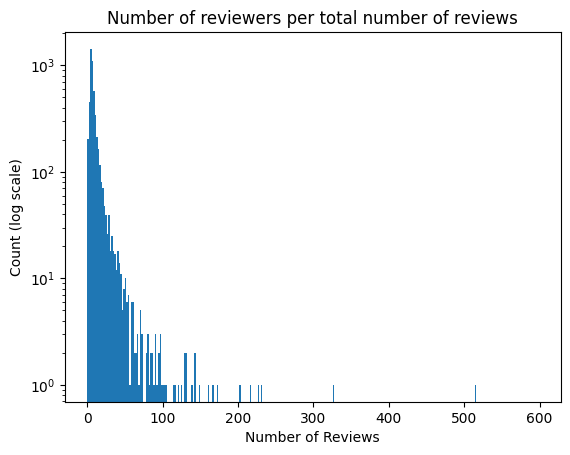

In [32]:
plt.hist(num_reviews_stats, buckets)
plt.yscale('log')
plt.title('Number of reviewers per total number of reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Count (log scale)')
plt.show()

We can see on the graph above that most people have less than 50 reviews, the number of people having high number of reviews decreases significantly and quickly.

In [33]:
items_scores_by_reviewer = {}
for reviewer, review_list in reviews_by_reviewer.items():
    my_item_scores = {review['asin']: review['overall'] for review in review_list}
    items_scores_by_reviewer[reviewer] = my_item_scores

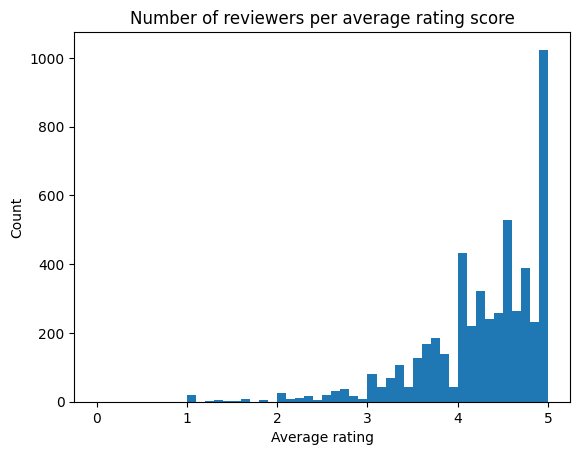

In [34]:
average_score_per_user = np.array([np.mean(list(review_dict.values())) for review_dict in items_scores_by_reviewer.values()])
buckets = np.arange(0, 5.1, 0.1)

plt.hist(average_score_per_user, buckets)
plt.title('Number of reviewers per average rating score')
plt.xlabel('Average rating')
plt.ylabel('Count')
plt.show()


In the graph above, we can see that most users have their average of all their ratings between 4 and 5.

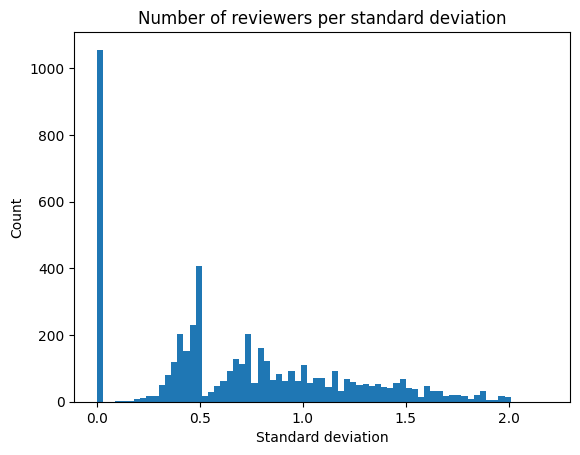

In [37]:
STD_score_per_user = np.array([np.std(list(review_dict.values())) for review_dict in items_scores_by_reviewer.values()])
buckets = np.arange(0, 2.2, 0.03)

plt.hist(STD_score_per_user, buckets)
plt.title('Number of reviewers per standard deviation')
plt.xlabel('Standard deviation')
plt.ylabel('Count')
plt.show()


## Step 1: removing users with insufficient reviews

It's possible that some users have only reviewed a few items, which makes it hard to estimate their true preferences. We can filter out users who have reviewed fewer than a certain number of items (e.g. 50) to ensure that we have enough data to estimate their preferences reliably.

In [13]:
# We only want the asin and the rating in our ditionary 
items_scores_by_reviewer = {}
for reviewer, review_list in reviews_by_reviewer.items():
    my_item_scores = {review['asin']: review['overall'] for review in review_list}
    items_scores_by_reviewer[reviewer] = my_item_scores

In [14]:
# Filter out reviewers with fewer than a constant number of reviews
MIN_NUM_REVIEWS = 50
reviews_by_reviewer_filtered_by_nb_of_reviews = {k:v for k,v in items_scores_by_reviewer.items() if len(v) >= MIN_NUM_REVIEWS}

In [15]:
# Printing the number of reviewers after filtering by number of reviews
print("Total number of reviewers with more than " + str(MIN_NUM_REVIEWS) + " reviews : " + str(len(reviews_by_reviewer_filtered_by_nb_of_reviews)))

Total number of reviewers with more than 50 reviews : 97


In [16]:
# Printing the first 5 items of the dictionary
# print(list(reviews_by_reviewer_filtered_by_nb_of_reviews.items())[:5])

## Step 2: removing users with low variance

If a user always gives high ratings (e.g., 4-5 stars), their reviews might not be informative for distinguishing between items that they like more or less. We can filter out reviews with low variance in their ratings to ensure that you focus on the items that the user is more likely to have a preference for.


In [17]:
# Filter out reviewers with fewer than a constant number of variance
MIN_VARIANCE = 1.0

# Create a dictionary to store the filtered dictionary
reviews_by_reviewer_filtered_by_variance = {}

# Loop through the reviews and add them to the dictionary
for key in reviews_by_reviewer_filtered_by_nb_of_reviews:
    reviewer_id = key
    reviews_dict = reviews_by_reviewer_filtered_by_nb_of_reviews[reviewer_id]
    n = len(reviews_dict.keys())

    # Calculating the average of all ratings for this particular reviewer
    avg = 0.
    for review_key in reviews_dict:
        review_rating = reviews_dict[review_key]
        avg += review_rating
    avg = avg / float(n)

    # Calculating the variance for this particular reviewer
    variance = 0.
    for reviews_key in reviews_dict:
        review_rating = reviews_dict[reviews_key]
        variance += (review_rating - avg)**2
    if(n > 1):
        variance /= n - 1

    # Adding this reviewer with their review to the dictionary if enough variance
    if(variance >= MIN_VARIANCE):
        reviews_by_reviewer_filtered_by_variance[reviewer_id] = reviews_dict

In [18]:
# Printing the number of reviewers after filtering by variance
print("Total number of reviewers with more than " + str(MIN_NUM_REVIEWS) + " reviews and " + str(MIN_VARIANCE) + " variance : " + str(len(reviews_by_reviewer_filtered_by_variance)))

Total number of reviewers with more than 50 reviews and 1.0 variance : 16


In [19]:
# Printing the first 5 items of the dictionary
print(list(reviews_by_reviewer_filtered_by_variance.items())[:5])

[('A2EENLV6OQ3DYM', {'B00000016T': 5.0, 'B00000064G': 4.0, 'B000000OQW': 3.0, 'B000000WGZ': 4.0, 'B000001DUK': 5.0, 'B000001DZO': 5.0, 'B000001E5X': 4.0, 'B000001EYI': 5.0, 'B000001F2S': 1.0, 'B000001F5Y': 3.0, 'B000001F6A': 2.0, 'B000001F6G': 1.0, 'B0000024SN': 3.0, 'B0000024UX': 4.0, 'B0000024YL': 5.0, 'B00000251D': 4.0, 'B000002564': 4.0, 'B0000025AD': 4.0, 'B0000025BA': 5.0, 'B0000025DD': 2.0, 'B0000025DT': 4.0, 'B0000025ED': 4.0, 'B0000025FG': 3.0, 'B0000025KF': 3.0, 'B0000025NU': 4.0, 'B00000264E': 1.0, 'B0000026M1': 4.0, 'B000002BFL': 2.0, 'B000002G7G': 4.0, 'B000002G8H': 5.0, 'B000002GQE': 3.0, 'B000002GVW': 4.0, 'B000002GWZ': 4.0, 'B000002GX2': 3.0, 'B000002GXU': 5.0, 'B000002GYL': 4.0, 'B000002H58': 4.0, 'B000002H8P': 4.0, 'B000002HQY': 4.0, 'B000002I9H': 3.0, 'B000002KD5': 5.0, 'B000002KHB': 5.0, 'B000002KXO': 3.0, 'B000002KYC': 4.0, 'B000002L7G': 4.0, 'B000002L82': 4.0, 'B000002LGQ': 4.0, 'B000002LN0': 2.0, 'B000002LSV': 4.0, 'B000002MH5': 5.0, 'B000002N61': 4.0, 'B000002O0

In [49]:
def plot_ratings_for_user(user_id, dictionary):
    ratings_count = {
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0
    }
    ratings_list = dictionary[user_id].values()
    for rating in ratings_list:
        ratings_count[rating] += 1

    ratings = sorted(ratings_count.items())

    x = [rating[0] for rating in ratings]
    y = [rating[1] for rating in ratings]

    plt.bar(x, y)
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.title('Ratings of user ' + user_id)
    plt.show()

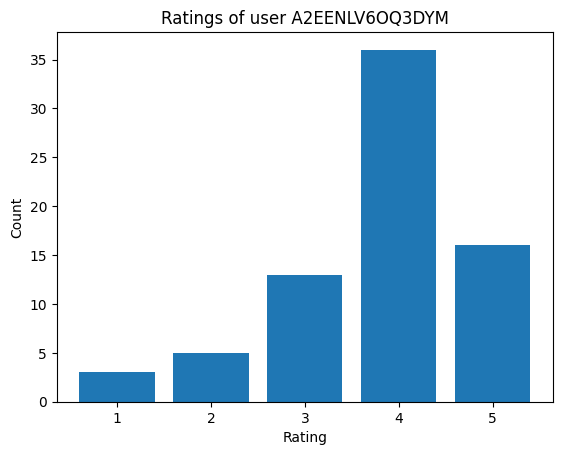

A2EENLV6OQ3DYM


In [71]:
# For sanity check
plot_ratings_for_user(list(reviews_by_reviewer_filtered_by_variance.keys())[0], reviews_by_reviewer_filtered_by_variance)

We can see that indeed, this user has enough ratings, and the ratings are diverse enough to be interesting for testing linear bandits

maximum number of reviews for a user :  515


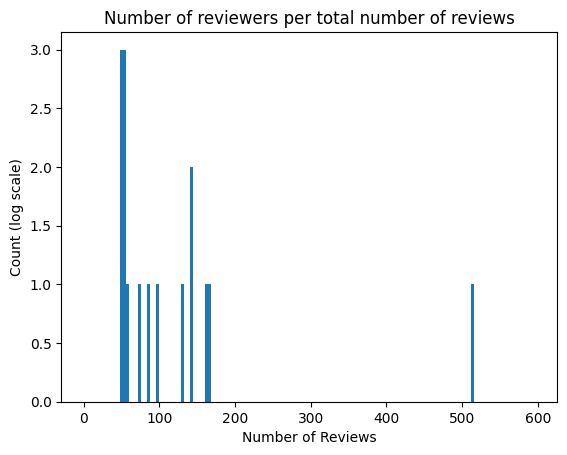

In [46]:
num_reviews_by_reviewer = {k:len(v.values()) for k,v in reviews_by_reviewer_filtered_by_variance.items()}
num_reviews_stats = np.array(list(num_reviews_by_reviewer.values()))
max_num_reviews = np.max(num_reviews_stats)
print("maximum number of reviews for a user : ", max_num_reviews)

buckets = np.arange(0, 600, 4)
plt.hist(num_reviews_stats, buckets)
plt.title('Number of reviewers per total number of reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Count (log scale)')
plt.show()

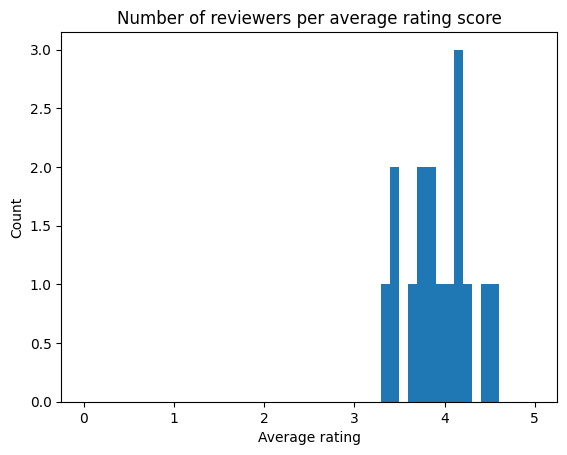

In [43]:
average_score_per_user = np.array([np.mean(list(review_dict.values())) for review_dict in reviews_by_reviewer_filtered_by_variance.values()])
buckets = np.arange(0, 5.1, 0.1)

plt.hist(average_score_per_user, buckets)
plt.title('Number of reviewers per average rating score')
plt.xlabel('Average rating')
plt.ylabel('Count')
plt.show()


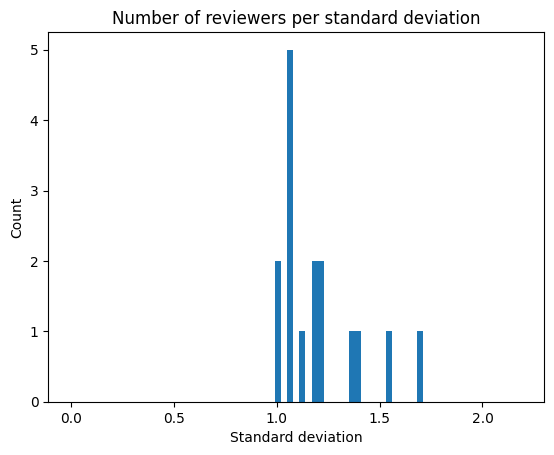

In [48]:
STD_score_per_user = np.array([np.std(list(review_dict.values())) for review_dict in reviews_by_reviewer_filtered_by_variance.values()])
buckets = np.arange(0, 2.2, 0.03)

plt.hist(STD_score_per_user, buckets)
plt.title('Number of reviewers per standard deviation')
plt.xlabel('Standard deviation')
plt.ylabel('Count')
plt.show()


### Exporting the results in a csv using pandas

In [86]:
# Convert the dictionary to a pandas dataframe
df = pd.DataFrame.from_dict(reviews_by_reviewer_filtered_by_variance, orient='index')

# Export the dataframe to a CSV file
df.to_csv('ratings_by_reviewer.csv', index_label='id')